### Import libraries for MNIST

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import os
from PIL import Image

### Load MNIST dataset from scikit-learn

In [4]:
mnist = fetch_openml('mnist_784')
data = mnist.data.to_numpy()
labels = mnist.target.to_numpy().astype(int)
print(f'Data shape: {data.shape}, Labels shape: {labels.shape}')

Data shape: (70000, 784), Labels shape: (70000,)


### Visualize the first digit

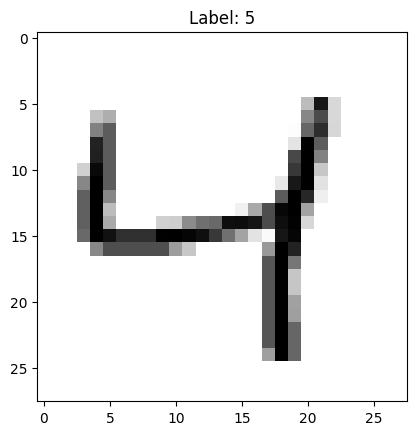

In [5]:
plt.imshow(data[2].reshape(28, 28), cmap=plt.cm.gray_r)
plt.title(f'Label: {labels[0]}')
plt.show()

### Split into train and test sets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42
)
print(f'Training set: {X_train.shape}, Test set: {X_test.shape}')

Training set: (56000, 784), Test set: (14000, 784)


In [7]:
X_train = X_train / 255.0
X_test  = X_test  / 255.0

In [8]:
# Split into m (number of samples) and n (number of features)
m, n = data.shape

In [9]:
print(X_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [10]:
y_train

array([5, 4, 8, ..., 1, 0, 0])

### Neural Network Class

In [ ]:
class SimpleNeuralNetwork:
    def __init__(self, input_size=784, hidden_size=64, output_size=10):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.initialize_weights()

    def initialize_weights(self):
        self.W1 = np.random.randn(self.hidden_size, self.input_size) * 0.01
        self.b1 = np.zeros((self.hidden_size, 1))
        self.W2 = np.random.randn(self.output_size, self.hidden_size) * 0.01
        self.b2 = np.zeros((self.output_size, 1))

    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        return (Z > 0).astype(float)

    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))
        return expZ / np.sum(expZ, axis=0, keepdims=True)

    def forward(self, X):
        self.Z1 = np.dot(self.W1, X) + self.b1
        self.A1 = self.relu(self.Z1)
        self.Z2 = np.dot(self.W2, self.A1) + self.b2
        self.A2 = self.softmax(self.Z2)
        return self.A2

    def compute_loss(self, Y_hat, Y):
        m = Y.shape[1]
        loss = -np.sum(Y * np.log(Y_hat + 1e-9)) / m
        return loss
    
    def compute_accuracy(self, Y_hat, Y):
        predictions = np.argmax(Y_hat, axis=0)
        true = np.argmax(Y, axis=0)
        accuracy = np.mean(predictions == true)
        return accuracy

    def backward(self, X, Y, Y_hat, lr):
        m = X.shape[1]

        dZ2 = Y_hat - Y
        dW2 = (1/m) * np.dot(dZ2, self.A1.T)
        db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)

        dA1 = np.dot(self.W2.T, dZ2)
        dZ1 = dA1 * self.relu_derivative(self.Z1)
        dW1 = (1/m) * np.dot(dZ1, X.T)
        db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

        self.W1 -= lr * dW1
        self.b1 -= lr * db1
        self.W2 -= lr * dW2
        self.b2 -= lr * db2

    def one_hot_encode(self, Y):
        one_hot = np.zeros((self.output_size, Y.size))
        one_hot[Y, np.arange(Y.size)] = 1
        return one_hot

    def train(self, X, Y_labels, epochs=100, lr=0.1):
        Y = self.one_hot_encode(Y_labels)
        loss_history = []
        acc_history = []

        for epoch in range(epochs):
            Y_hat = self.forward(X)
            loss = self.compute_loss(Y_hat, Y)
            acc = self.compute_accuracy(Y_hat, Y)
            self.backward(X, Y, Y_hat, lr)
            loss_history.append(loss)
            acc_history.append(acc)
            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f} - Accuracy: {acc:.4f}")

        return loss_history, acc_history

    def accuracy(self, X, Y_labels):
        Y_hat = self.forward(X)
        predictions = np.argmax(Y_hat, axis=0)
        return np.mean(predictions == Y_labels)

    def get_weights(self):
        return [self.W1, self.b1, self.W2, self.b2]

    def set_weights(self, weights):
        self.W1, self.b1, self.W2, self.b2 = weights

    def flatten_weights(self):
        return np.concatenate([w.flatten() for w in self.get_weights()])

    def unflatten_weights(self, flat_weights):
        shapes = [self.W1.shape, self.b1.shape, self.W2.shape, self.b2.shape]
        weights = []
        idx = 0
        for shape in shapes:
            size = np.prod(shape)
            weights.append(flat_weights[idx:idx + size].reshape(shape))
            idx += size
        self.set_weights(weights)
    
    def evaluate_solution(self, weights):
        self.set_weights(weights)
        y_pred = self.forward(X_train)
        loss = self.compute_loss(y_pred, y_train)
        return loss


### Train NN

In [37]:
# Initialize and train
model = SimpleNeuralNetwork()
losses, accuracies = model.train(X_train.T, y_train, epochs=200, lr=0.1)

# Evaluate
acc = model.accuracy(X_train.T, y_train)
print(f"Training Accuracy: {acc * 100:.2f}%")

Epoch 1/200 - Loss: 2.3029 - Accuracy: 0.0838
Epoch 10/200 - Loss: 2.2975 - Accuracy: 0.2703
Epoch 20/200 - Loss: 2.2872 - Accuracy: 0.4378
Epoch 30/200 - Loss: 2.2648 - Accuracy: 0.4186
Epoch 40/200 - Loss: 2.2168 - Accuracy: 0.4002
Epoch 50/200 - Loss: 2.1243 - Accuracy: 0.4544
Epoch 60/200 - Loss: 1.9710 - Accuracy: 0.5596
Epoch 70/200 - Loss: 1.7542 - Accuracy: 0.6465
Epoch 80/200 - Loss: 1.5069 - Accuracy: 0.6860
Epoch 90/200 - Loss: 1.2839 - Accuracy: 0.7163
Epoch 100/200 - Loss: 1.1100 - Accuracy: 0.7463
Epoch 110/200 - Loss: 0.9791 - Accuracy: 0.7701
Epoch 120/200 - Loss: 0.8789 - Accuracy: 0.7892
Epoch 130/200 - Loss: 0.8004 - Accuracy: 0.8034
Epoch 140/200 - Loss: 0.7377 - Accuracy: 0.8150
Epoch 150/200 - Loss: 0.6869 - Accuracy: 0.8260
Epoch 160/200 - Loss: 0.6452 - Accuracy: 0.8345
Epoch 170/200 - Loss: 0.6105 - Accuracy: 0.8423
Epoch 180/200 - Loss: 0.5812 - Accuracy: 0.8492
Epoch 190/200 - Loss: 0.5561 - Accuracy: 0.8555
Epoch 200/200 - Loss: 0.5345 - Accuracy: 0.8602
Tra

### DE optimization function

In [ ]:
def differential_evolution(model, X, Y_labels, population_size=20, generations=50,
                           F=0.5, CR=0.7, target_loss=0.1, target_acc=0.90):
    dim = model.flatten_weights().shape[0]

    def evaluate_vector(flat_weights):
        model.unflatten_weights(flat_weights)
        Y_hat = model.forward(X)
        Y = model.one_hot_encode(Y_labels)
        loss = model.compute_loss(Y_hat, Y)
        acc = model.compute_accuracy(Y_hat, Y)
        return loss, acc

    # Initialize population
    population = np.random.uniform(low=-1, high=1, size=(population_size, dim))
    fitness = np.array([evaluate_vector(ind) for ind in population])

    # Track best solution
    best_idx = np.argmin(fitness)
    best_vector = population[best_idx]
    best_loss = fitness[best_idx][0]
    best_accuracy = fitness[best_idx][1]
    
    # History lists
    losses = []
    accuracies = []

    print("Starting DE optimization...\n")
    for gen in range(generations):
        for i in range(population_size):
            # Select 3 other individuals
            idxs = [idx for idx in range(population_size) if idx != i]
            a, b, c = population[np.random.choice(idxs, 3, replace=False)]

            # Mutation
            mutant = a + F * (b - c)
            mutant = np.clip(mutant, -1, 1)

            # Crossover
            cross_points = np.random.rand(dim) < CR
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dim)] = True
            trial = np.where(cross_points, mutant, population[i])

            # Selection
            trial_loss, trial_acc = evaluate_vector(trial)
            if trial_loss < fitness[i][0]:
                population[i] = trial
                fitness[i][0] = trial_loss
                fitness[i][1] = trial_acc

                if (trial_loss < best_loss) and (trial_acc > best_accuracy):
                    best_loss = trial_loss
                    best_accuracy = trial_acc
                    best_vector = trial.copy()
            
            losses.append(trial_loss)
            accuracies.append(trial_acc)

        print(f"Generation {gen+1}/{generations} - Best Loss: {best_loss:.4f} - Best Accuracy: {best_accuracy:.4f}")
        
        # Early stopping
        if best_loss <= target_loss or best_accuracy >= target_acc:
            print(f"\nStopping early at gen {gen}: - Reached loss ≤ {target_loss} or acc ≥ {target_acc}")
            break

    print("\nDE optimization finished.")
    model.unflatten_weights(best_vector)
    
    return {
        'best_loss': best_loss,
        'best_accuracy': best_accuracy,
        'losses': losses,
        'accuracies': accuracies
    }


### Train DE

In [ ]:
# Initialize model
model_de = SimpleNeuralNetwork()

# Run DE optimizer
results = differential_evolution(model_de, X_train.T, y_train, population_size=10, generations=200)

# Evaluate accuracy
acc_de = model_de.accuracy(X_train.T, y_train)
print(f"DE Accuracy: {acc_de * 100:.2f}%")

Starting DE optimization...

Generation 1/200 - Best Loss: 14.3220 - Best Accuracy: 0.1205
Generation 2/200 - Best Loss: 14.5947 - Best Accuracy: 0.1218
Generation 3/200 - Best Loss: 13.8574 - Best Accuracy: 0.1263
Generation 4/200 - Best Loss: 12.2103 - Best Accuracy: 0.1472
Generation 5/200 - Best Loss: 12.2103 - Best Accuracy: 0.1472
Generation 6/200 - Best Loss: 12.2103 - Best Accuracy: 0.1472
Generation 7/200 - Best Loss: 12.2103 - Best Accuracy: 0.1472
Generation 8/200 - Best Loss: 12.1527 - Best Accuracy: 0.1525
Generation 9/200 - Best Loss: 13.2301 - Best Accuracy: 0.1638
Generation 10/200 - Best Loss: 12.3722 - Best Accuracy: 0.1424
Generation 11/200 - Best Loss: 12.3722 - Best Accuracy: 0.1424
Generation 12/200 - Best Loss: 12.3722 - Best Accuracy: 0.1424
Generation 13/200 - Best Loss: 13.9181 - Best Accuracy: 0.1246
Generation 14/200 - Best Loss: 12.5125 - Best Accuracy: 0.1554
Generation 15/200 - Best Loss: 12.5125 - Best Accuracy: 0.1554
Generation 16/200 - Best Loss: 11.3

### Visualize [NN, DE] models

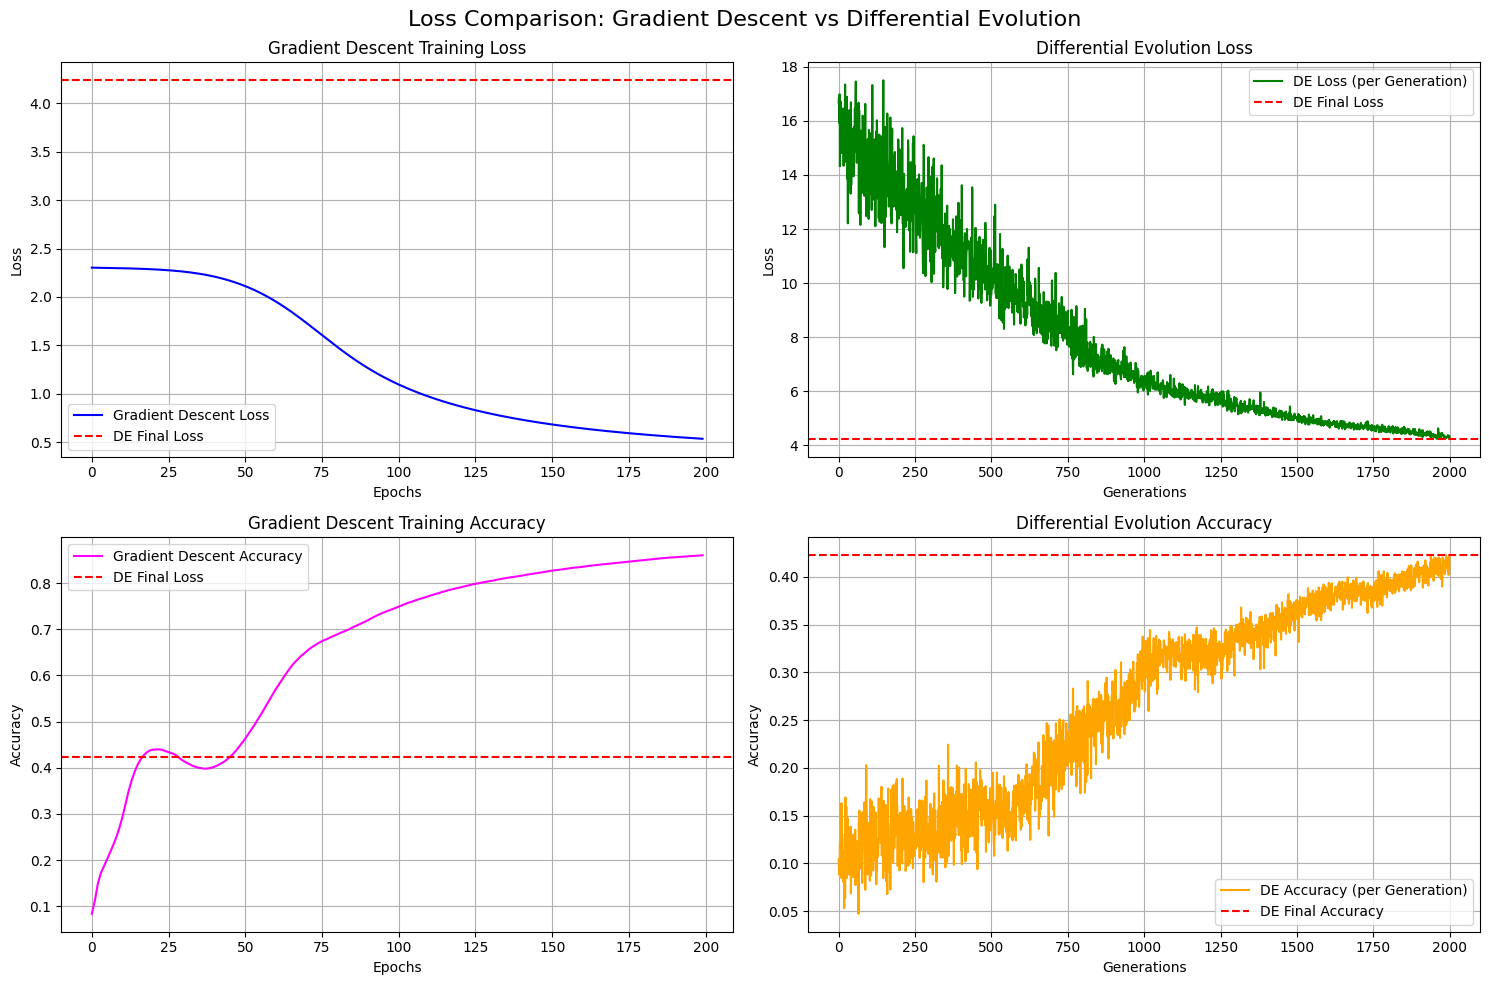

In [40]:
plt.figure(figsize=(15, 10))

# Plot 1: Gradient Descent Losses with DE Final Loss as reference
plt.subplot(2, 2, 1)
plt.plot(losses, label="Gradient Descent Loss", color='blue')
plt.axhline(results["best_loss"], color='red', linestyle='--', label="DE Final Loss")
plt.title("Gradient Descent Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot 2: Differential Evolution Losses (if recorded) with Final Loss
plt.subplot(2, 2, 2)
plt.plot(results["losses"], label="DE Loss (per Generation)", color='green')
plt.axhline(results["best_loss"], color='red', linestyle='--', label="DE Final Loss")
plt.title("Differential Evolution Loss")
plt.xlabel("Generations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot 3: Gradient Descent Accuracies with DE Final Accuracy as reference
plt.subplot(2, 2, 3)
plt.plot(accuracies, label="Gradient Descent Accuracy", color='magenta')
plt.axhline(results["best_accuracy"], color='red', linestyle='--', label="DE Final Loss")
plt.title("Gradient Descent Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Plot 4: Differential Evolution accuracies (if recorded) with Final Accuracy
plt.subplot(2, 2, 4)
plt.plot(results["accuracies"], label="DE Accuracy (per Generation)", color='orange')
plt.axhline(results["best_accuracy"], color='red', linestyle='--', label="DE Final Accuracy")
plt.title("Differential Evolution Accuracy")
plt.xlabel("Generations")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.suptitle("Loss Comparison: Gradient Descent vs Differential Evolution", fontsize=16)
plt.tight_layout()
plt.show()

### Sample prediction

In [62]:
def predict(folder_path, models):
  
  results = {}
  
  for filename in sorted(os.listdir(folder_path)):
    
    if not filename.endswith(('.png', '.jpg', '.jpeg')):
      continue
    
    img = Image.open(os.path.join(folder_path, filename)).convert('L')
    img = img.resize((28, 28))
    arr = np.array(img).astype(np.float32)
    arr = 1.0 - (arr / 255.0)
    
    x_input = arr.flatten().reshape(-1, 1) # Reshape to (784, 1)
    
    per_image_predictions = {}
    
    for name, model in models.items():
      y_hat = model.forward(x_input)
      prediction = np.argmax(y_hat, axis=0)[0]
      per_image_predictions[name] = prediction
    
    results[filename] = per_image_predictions
  
  return results

predictions = predict('handwritten_samples', {'Gradient Descent': model, 'Differential Evolution': model_de})

for filename, preds in predictions.items():
  print(f"{filename} -> ", end="")
  print(", ".join(f"{model_name}: {model_pred}" for model_name,model_pred in preds.items()))

Number_1.png -> Gradient Descent: 8, Differential Evolution: 3
Number_2.png -> Gradient Descent: 2, Differential Evolution: 1
Number_3.png -> Gradient Descent: 3, Differential Evolution: 3
Number_4.png -> Gradient Descent: 4, Differential Evolution: 4
Number_5.png -> Gradient Descent: 5, Differential Evolution: 6
Number_6.png -> Gradient Descent: 6, Differential Evolution: 2
Number_7.png -> Gradient Descent: 8, Differential Evolution: 3
Number_8.png -> Gradient Descent: 6, Differential Evolution: 0
Number_9.png -> Gradient Descent: 9, Differential Evolution: 9
